In [2]:
from common_imports import *

In [3]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
FIGURES_ROOT = Path('figures/')
EXP_OUTPUT_ROOT = Path('patching_exp_outputs/')

# Loading and preprocessing results

In [12]:
patching_results = joblib.load(EXP_OUTPUT_ROOT / 'fact_patching_results.joblib')
best_vs, norm_metrics_df, patching_metrics_df, exp_facts = patching_results

def add_logitdiffs_as_fractions_of_clean(df: pd.DataFrame):
    layer_and_idx_to_clean_ld = {}
    for layer in df['layer'].unique():
        for fact_idx in df['fact_idx'].unique():
            clean_ld = df.query(f'layer == {layer} and fact_idx == {fact_idx} and method == "clean"')['ld'].values[0]
            layer_and_idx_to_clean_ld[(layer, fact_idx)] = clean_ld
    # now apply the transformation on rows
    df['ld_fraction'] = df.apply(lambda row: row['ld'] / layer_and_idx_to_clean_ld[(row['layer'], row['fact_idx'])], axis=1)
    return df
add_logitdiffs_as_fractions_of_clean(df=patching_metrics_df)


editing_result_rows = joblib.load(EXP_OUTPUT_ROOT / 'rank1_editing_results.joblib')
correlation_df = pd.DataFrame([
    {'layer': d['layer'], 
     'fact_idx': d['fact_idx'],
     'act_diff_sim_to_row': np.abs(d['act_diff_sim_to_row']),
     'act_diff_sim_to_null': np.abs(d['act_diff_sim_to_null']),
    } for d in editing_result_rows
])

def get_rank1_metrics(editing_result_rows: List[dict]):
    result_rows = []
    for d in editing_result_rows:
        result_rows.append({
            'method': 'rome',
            'ld': d['edit_logit_diff'],
            'predict_source': d['edit_predicts_source'],
            'predict_base': d['edit_predicts_base'],
            'prediction': d['edit_prediction'],
            'layer': d['layer'],
            'fact_idx': d['fact_idx'],
        })
    return pd.DataFrame(result_rows)

def convert_fact_patch_example_to_rome_request(
    fp_example: dict) -> dict:
    request = {
        "prompt": fp_example['prompt'],
        "subject": fp_example['base_subject'],
        "target_new": {"str": fp_example['source_target']},
    }
    return request

def dump_rome_requests(exp_facts: List[dict]):
    rome_requests = [convert_fact_patch_example_to_rome_request(fp_example) for fp_example in exp_facts]
    with open('rome_requests.json', 'w') as f:
        json.dump(rome_requests, f)
dump_rome_requests(exp_facts)

def load_rome_edits_from_fact_patches():
    """
    Return a list of dictionaries where each entry is of the form 
    {'fact_idx': i, 'layer': j, 'u': u, 'v': v}
    for u, v being ROME left/right edit vectors 
    """
    fact_patching_rome_edit_rows = joblib.load('fact_patching_rome_edit_rows.joblib')
    return fact_patching_rome_edit_rows
fact_patching_rome_edit_rows = load_rome_edits_from_fact_patches()

patching_metrics_rank1 = get_rank1_metrics(editing_result_rows)
das_and_rank1_df = pd.merge(left=patching_metrics_rank1, 
         right=patching_metrics_df.query('method == "das"'),
         on=['layer', 'fact_idx'], suffixes=('_rank1', '_das'))
das_and_rank1_df['ld'] = das_and_rank1_df['ld_rank1'] - das_and_rank1_df['ld_das']
das_and_rank1_df['predict_source'] = das_and_rank1_df['predict_source_rank1']

das_and_rank1_ld_df = pd.melt(das_and_rank1_df, id_vars=['layer', 'fact_idx', ], value_vars=['ld_rank1', 'ld_das'], var_name='method', value_name='logit_diff')
das_and_rank1_acc_df = pd.melt(das_and_rank1_df, id_vars=['layer', 'fact_idx', ], value_vars=['predict_source_rank1', 'predict_source_das'], var_name='method', value_name='fact_flip')

# Generating fact patching figures

/tmp/ipykernel_47640/233952511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['method'] = df['method'].map({'row': 'DAS rowspace component', 'das': 'DAS', 'full_mlp': 'Full MLP patch'})


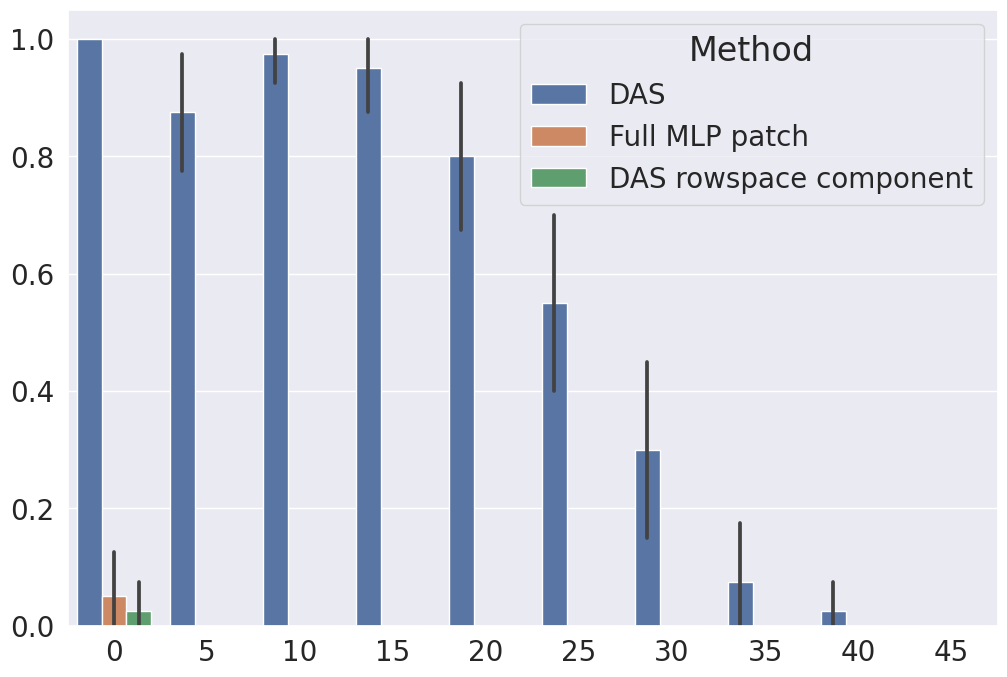

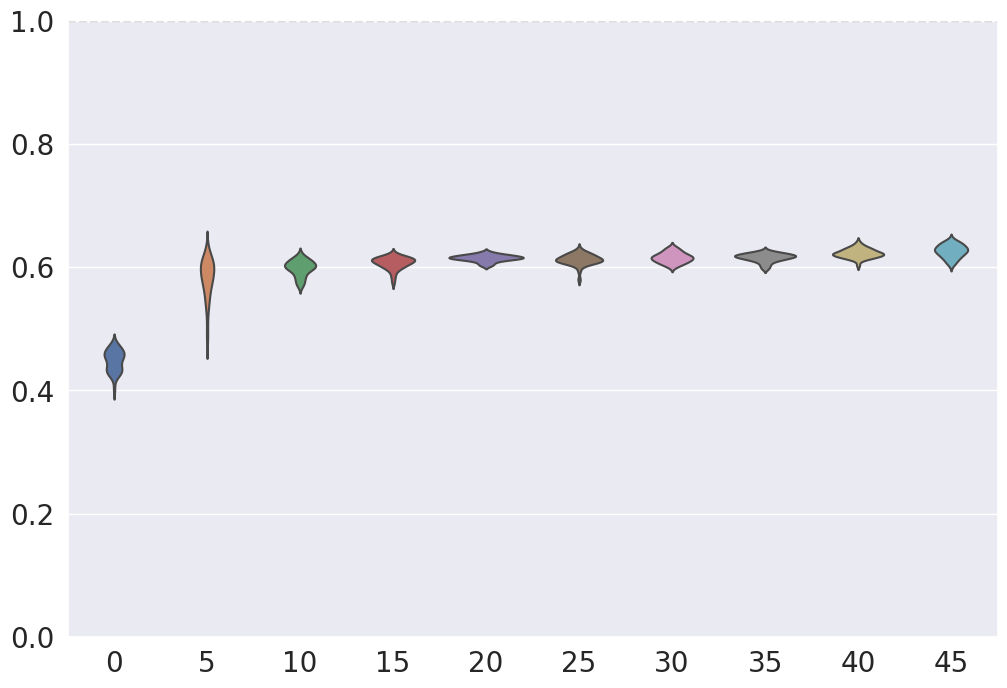

/tmp/ipykernel_47640/233952511.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['method'] = df['method'].map({'row': 'DAS rowspace component', 'das': 'DAS', 'full_mlp': 'Full MLP patch'})


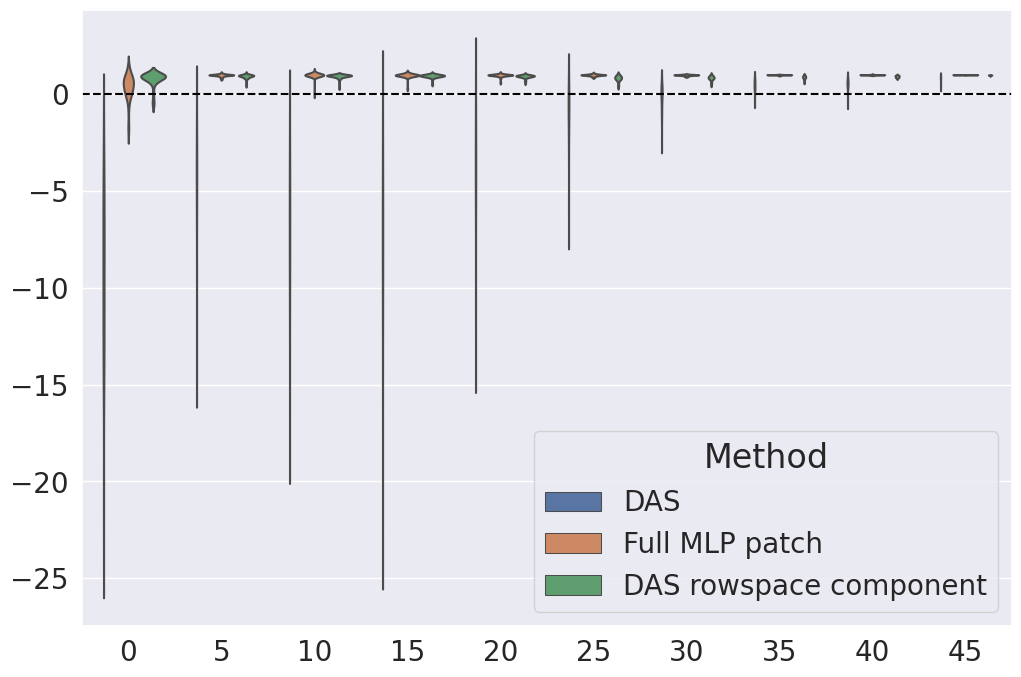

In [4]:
################################################################################
### Bar plot of fraction of facts flipped by das, rowspace and full mlp patch
################################################################################
df = patching_metrics_df.query('method in ["row", "das", "full_mlp"]') 
df['method'] = df['method'].map({'row': 'DAS rowspace component', 'das': 'DAS', 'full_mlp': 'Full MLP patch'})
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='layer', y='predict_source', hue='method')
# remove the x, y axis titles
plt.xlabel('')
plt.ylabel('')
# increase the font of the x and y ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# increase legend font size
# set legend title
plt.legend(title='Method', title_fontsize=24, fontsize=20)
# plt.show()
# save the figure to disk
plt.savefig(FIGURES_ROOT / 'fact-patching-barplot.pdf', format='pdf', bbox_inches='tight')

################################################################################
### violin plot of the norm of the nullspace component of the patch
################################################################################
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="layer", y="null_norm", data=norm_metrics_df, inner=None,)
# indicate the fraction of points for a given layer where the edit predicts the
# source
# sns.stripplot(x="layer", y="ld", hue="predict_source", data=df, jitter=True, dodge=True)
# add a horizontal line at 0
plt.axhline(1, color='black', linestyle='--')
# add a vertical line at the layer where the edit predicts the source most often
# plt.axvline(df.groupby('layer')['predict_source'].mean().idxmax(), color='black', linestyle='--')
# put legend in LOWER right
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# set y limits to (0, 1 
plt.ylim(0, 1)
# increase legend font size
# set legend title
# plt.title('Logit difference between source and base predictions', fontsize=24)
plt.xlabel(None)
plt.ylabel(None)
plt.savefig(FIGURES_ROOT / 'fact-patching-norm-violins.pdf', format='pdf', bbox_inches='tight')
plt.show()

################################################################################
### violin plots of logit difference distribution for each layer for each method
################################################################################
plt.figure(figsize=(12, 8))
df = patching_metrics_df.query('method in ["row", "das", "full_mlp"]') 
# create a violin plot of logit difference on the y axis and layer on the x axis
# no hue
df['method'] = df['method'].map({'row': 'DAS rowspace component', 'das': 'DAS', 'full_mlp': 'Full MLP patch'})
ax = sns.violinplot(x="layer", y="ld_fraction", data=df, inner=None, hue='method')
# indicate the fraction of points for a given layer where the edit predicts the
# source
# sns.stripplot(x="layer", y="ld", hue="predict_source", data=df, jitter=True, dodge=True)
# add a horizontal line at 0
plt.axhline(0, color='black', linestyle='--')
# add a vertical line at the layer where the edit predicts the source most often
# plt.axvline(df.groupby('layer')['predict_source'].mean().idxmax(), color='black', linestyle='--')
# put legend in LOWER right
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# increase legend font size
# set legend title
plt.legend(title='Method', title_fontsize=24, fontsize=20, loc='lower right')
# plt.title('Logit difference between source and base predictions', fontsize=24)
plt.xlabel(None)
plt.ylabel(None)
plt.savefig(FIGURES_ROOT / 'fact-patching-logitdiff-violins.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Generating rank-1 editing figures

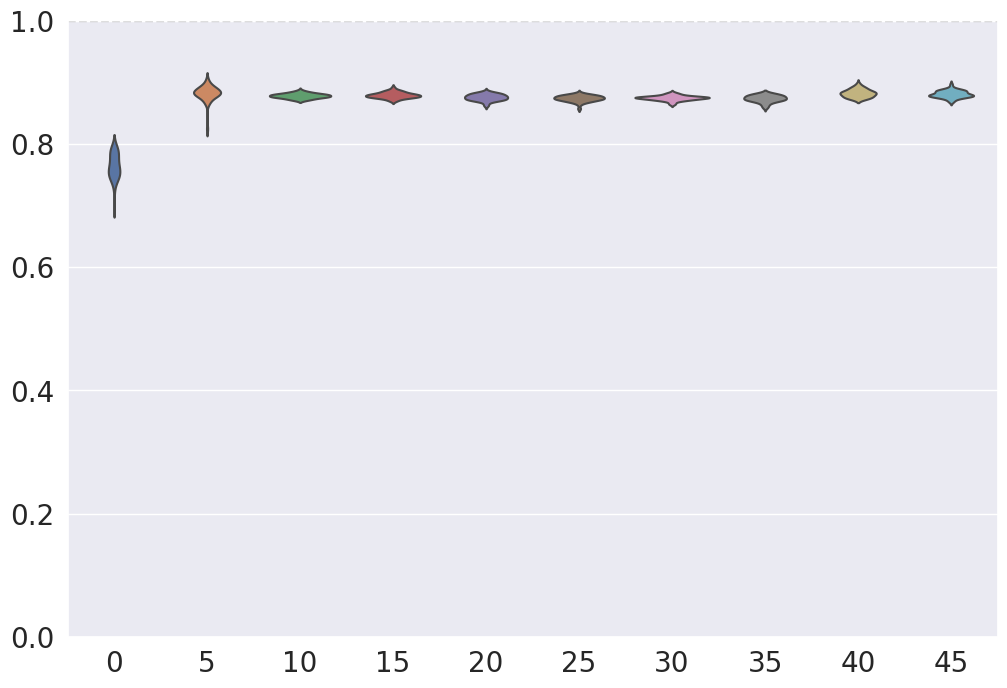

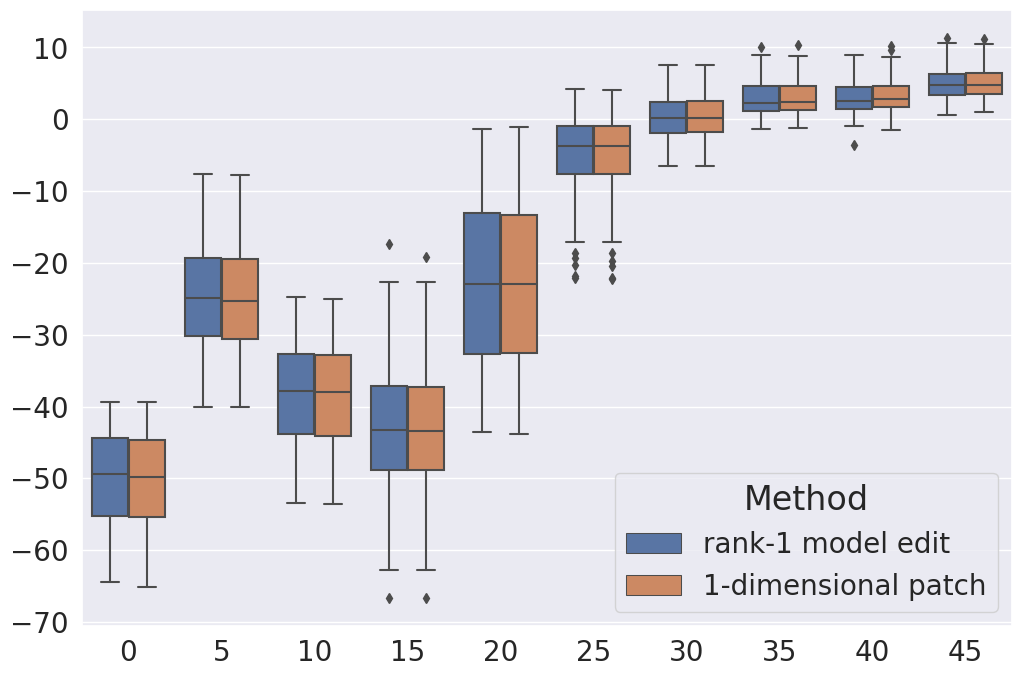

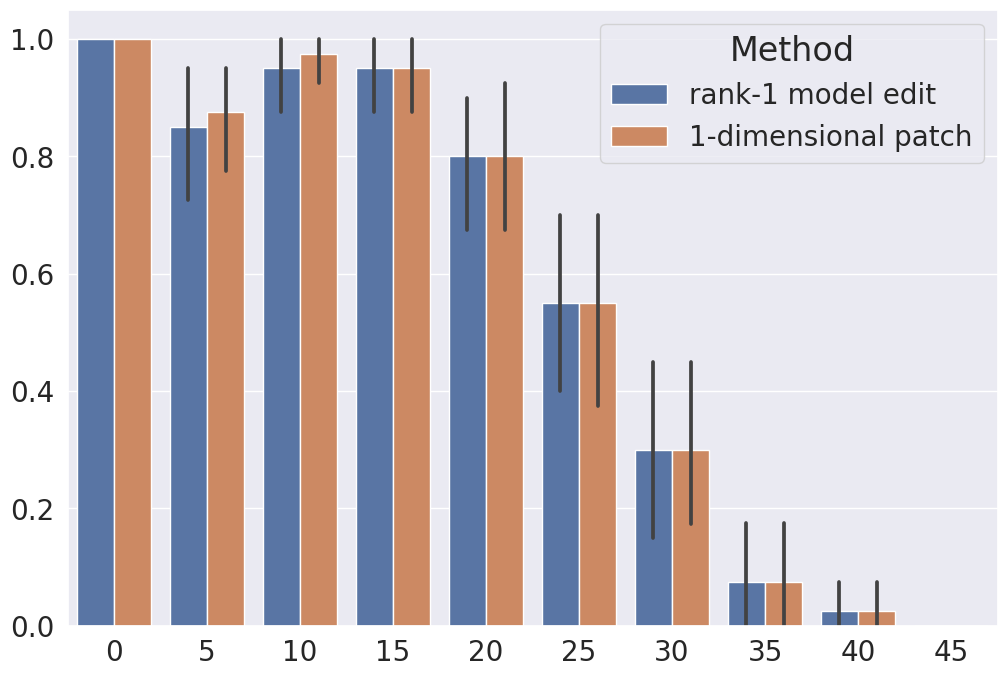

In [5]:
################################################################################
### violin plot of the dot product between the nullspace component of the patch
### and the difference in the activations of the source and target
################################################################################
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x="layer", y="act_diff_sim_to_null", data=correlation_df, inner=None,)
# indicate the fraction of points for a given layer where the edit predicts the
# source
# sns.stripplot(x="layer", y="ld", hue="predict_source", data=df, jitter=True, dodge=True)
# add a horizontal line at 0
plt.axhline(1, color='black', linestyle='--')
# add a vertical line at the layer where the edit predicts the source most often
# plt.axvline(df.groupby('layer')['predict_source'].mean().idxmax(), color='black', linestyle='--')
# put legend in LOWER right
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# set y limits to (0, 1 
plt.ylim(0, 1)
# increase legend font size
# set legend title
# plt.title('Logit difference between source and base predictions', fontsize=24)
plt.xlabel(None)
plt.ylabel(None)
plt.savefig(FIGURES_ROOT / 'fact-patching-correlation-violins.pdf', format='pdf', bbox_inches='tight')
plt.show()

################################################################################
### box plots comparing logit difference for rank1 edits and das patches by layer
################################################################################
plt.figure(figsize=(12, 8))
das_and_rank1_ld_df['display_method'] = das_and_rank1_ld_df['method'].apply(lambda x: 'rank-1 model edit' if x == 'ld_rank1' else '1-dimensional patch')
ax = sns.boxplot(x="layer", y="logit_diff", hue="display_method", data=das_and_rank1_ld_df)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title='Method', title_fontsize=24, fontsize=20)
plt.savefig(FIGURES_ROOT / 'fact-patching-rank1-vs-das-ld.pdf', format='pdf', bbox_inches='tight')
plt.show()

### bar plot of interchange accuracy
plt.figure(figsize=(12, 8))
das_and_rank1_acc_df['display_method'] = das_and_rank1_acc_df['method'].apply(lambda x: 'rank-1 model edit' if x == 'predict_source_rank1' else '1-dimensional patch')
ax = sns.barplot(x="layer", y="fact_flip", hue="display_method", data=das_and_rank1_acc_df)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title='Method', title_fontsize=24, fontsize=20)
# set y limits to (0, 1 
# increase legend font size
# set legend title
# plt.title('Logit difference between source and base predictions', fontsize=24)
plt.xlabel(None)
plt.ylabel(None)
plt.savefig(FIGURES_ROOT / 'fact-patching-rank1-vs-das-acc.pdf', format='pdf', bbox_inches='tight')
plt.show()